# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [30]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [32]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.386094
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *W为随机生成，W每列具有同样的分布，因此对于一条观测来说，预测为每个类别的概率均服从一个均值为0.1的分布(本题是一个十分类问题)。根据大数定理，可近似认为交叉熵平均值为-log(0.1)* 



<font color=red size=4>你是全班唯一一个提到大数的人，但是那个叫大数定律:-)</font>

In [33]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.676860 analytic: -0.676860, relative error: 2.305631e-08
numerical: -2.616813 analytic: -2.616813, relative error: 1.863526e-08
numerical: 0.074052 analytic: 0.074052, relative error: 9.391658e-07
numerical: -1.171329 analytic: -1.171329, relative error: 1.051347e-08
numerical: 1.911658 analytic: 1.911658, relative error: 3.476064e-08
numerical: -0.805295 analytic: -0.805295, relative error: 1.686595e-08
numerical: 0.400940 analytic: 0.400940, relative error: 7.787363e-08
numerical: -2.321848 analytic: -2.321848, relative error: 1.095205e-09
numerical: -0.096617 analytic: -0.096618, relative error: 2.957869e-07
numerical: -1.803658 analytic: -1.803658, relative error: 1.968700e-08
numerical: 1.658320 analytic: 1.658320, relative error: 3.511539e-08
numerical: -1.703631 analytic: -1.703631, relative error: 1.082749e-08
numerical: 2.976805 analytic: 2.976805, relative error: 2.210772e-08
numerical: 0.834629 analytic: 0.834629, relative error: 5.046808e-09
numerical: -2.3452

In [36]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.386094e+00 computed in 0.148564s
vectorized loss: 2.386094e+00 computed in 0.004992s
Loss difference: 0.000000
Gradient difference: 0.000000


In [64]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [5e-8,1e-7, 5e-7,1e-6]
regularization_strengths = [1e4, 2.5e4, 5e4, 1e5]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        tmp_softmax = Softmax()
        softmax_plot = tmp_softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)
        y_train_pred, y_val_pred = tmp_softmax.predict(X_train), tmp_softmax.predict(X_val)
        tmp_tr, tmp_val = np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred)
        
        results[(lr, reg)] = (tmp_tr, tmp_val)
        if best_val < tmp_val :
            best_softmax, best_val = tmp_softmax, tmp_val

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 5.000000e-08 reg 1.000000e+04 train accuracy: 0.297551 val accuracy: 0.302000
lr 5.000000e-08 reg 2.500000e+04 train accuracy: 0.328163 val accuracy: 0.341000
lr 5.000000e-08 reg 5.000000e+04 train accuracy: 0.305469 val accuracy: 0.319000
lr 5.000000e-08 reg 1.000000e+05 train accuracy: 0.286571 val accuracy: 0.300000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.352755 val accuracy: 0.359000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.326837 val accuracy: 0.336000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.304367 val accuracy: 0.319000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.294306 val accuracy: 0.303000
lr 5.000000e-07 reg 1.000000e+04 train accuracy: 0.353102 val accuracy: 0.375000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.331061 val accuracy: 0.335000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.301265 val accuracy: 0.324000
lr 5.000000e-07 reg 1.000000e+05 train accuracy: 0.295041 val accuracy: 0.306000
lr 1.000000e-06 reg 1.000000

In [65]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.362000


In [66]:
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=False)

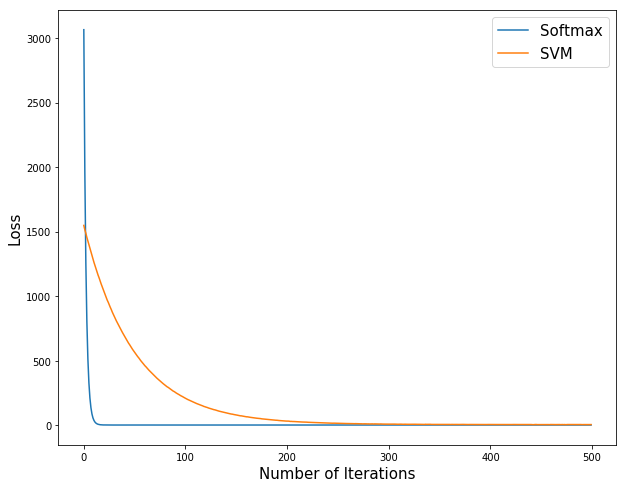

In [67]:
plt.plot(softmax_plot[0:500], label='Softmax')
plt.plot(loss_hist[0:500], label='SVM')
plt.legend(bbox_to_anchor=(1, 1), fontsize=15)
plt.xlabel('Number of Iterations', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.show()

上图用上次作业得到的SVM和得到的Softmax进行比较，发现Softmax收敛速度较快

**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ True


$\color{blue}{\textit Your Explanation:}$一个数据点SVM的损失函数如下

\begin{equation}%
Loss=\sum\nolimits_{j≠y_i}max(0,s_j-s_{y_i}+1),y_i为该第i个观测真实的分类结果
\end{equation}
如果新的数据点$s_{y_i}$大于所有的$s_j+1$($j≠y_i$)，那么SVM的loss不变。

一个数据点Softmax的损失函数如下
\begin{equation}%
Loss=\sum\nolimits_{i}y_i ln(\frac{e^{z_i}}{\sum\nolimits_{k}e^{z_k}}),y_i为该第i个观测真实的分类结果时取1，否则为0
\end{equation}
${\sum\nolimits_{k}e^{z_k}}>e^{z_i}$恒成立，因此对数恒不等于零，即损失函数恒不为零，因此新增一个数据点会使得损失函数的和变化。


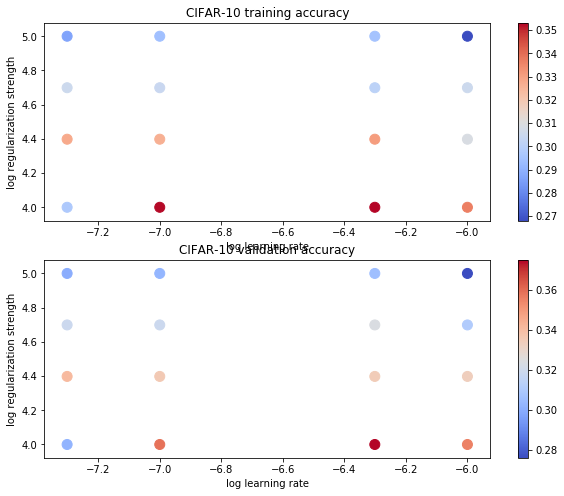

In [68]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

这一次并没有看出来学习率和正则化组合取值与准确率的关系

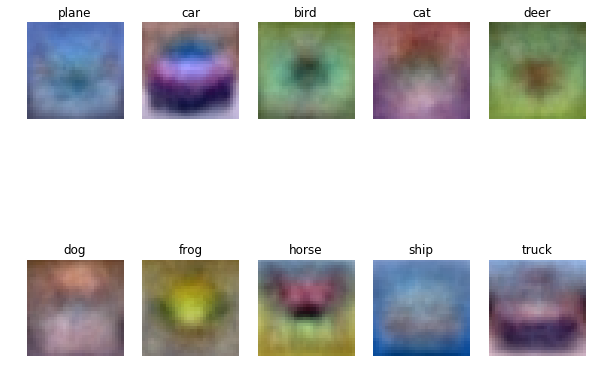

In [69]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])